In [182]:
from common import *
from search.imports import *
from features.FFF import FFF

In [74]:
Feats = namedtuple('Feats', 'feats sampsdata')
Samps = namedtuple('Samps', 'samps paramsdata')
Params = namedtuple('Params', 'params results')

In [75]:
class LineFeed():
    class FinishFeed(StopIteration):
        pass
    def __init__(self, feed):
        if feed is not None:
            self.feed = iter(feed)
            self.line = next(feed)
        else:
            self.feed = None
            self.line = None
    def __next__(self):
        line = self.line
        try:
            self.line = next(self.feed)
        except StopIteration:
            self.line = None
            self.feed = None
            raise __class__.FinishFeed()
        return line
    
def until(func):
    @wraps(func)
    def until_func(lf):
        while True:
            if lf.line is None:
                raise LineFeed.FinishFeed()
            x = func(lf)
            if x is None:
                next(lf)
            else:
                return x
    return until_func

In [138]:
def see_t(lf):
    if lf.line[:8] != '>>> t = ':
        return None
    ans = int(lf.line[8:lf.line[8:].index('=')+8])
    return ans

def get_feats(lf):
    if lf.line[:10] != 'len(feats)':
        return None
    next(lf)
    ans = []
    while lf.line[:10] != 'len(samps)':
        ans.append(next(lf))
    return '\n'.join(ans)

def get_samps(lf):
    if lf.line[:10] != 'len(samps)':
        return None
    next(lf)
    ans = eval(next(lf))
    return ans

def see_k(lf):
    if lf.line[:8] == '>>> t = ':
        return -1
    if lf.line[:9] != '>>>  k = ':
        return None
    ans = int(lf.line[9:lf.line[9:].index('-')+9])
    return ans

def get_params(lf):
    if lf.line[0] != '{':
        return None
    p1 = eval(next(lf))
    p2 = eval(next(lf))
    return dict(**p1, **p2)

def get_results(lf):
    if lf.line[:8] != 'nboost =':
        return None
    o = O()
    exec(next(lf), o) # nboost
    exec(next(lf), o) # train
    exec(next(lf), o) # scores
    exec(next(lf), o) # score
    return O(nboost=o.nboost, train=o.train, scores=o.scores, score=o.score)

In [148]:
def iter_load_params(lf):
    while True:
        try:
            k = until(see_k)(lf)
            if k==-1:
                break
            params = until(get_params)(lf)
            results = until(get_results)(lf)
            yield Params(params, results)
        except LineFeed.FinishFeed:
            break

def iter_load_samps(lf, tf):
    '''first iter is actually the feats due to technicality in the log's structure'''
    for i in range(999999999):
        try:
            t = until(see_t)(lf)
            tf1, ts = divmod(t, 100)
            if tf1!=tf:
                break
            feats = until(get_feats)(lf)
            if i==0:
                yield feats
            samps = until(get_samps)(lf)
            yield Samps(samps, list(iter_load_params(lf)))
        except LineFeed.FinishFeed:
            break

def iter_load_feats(lf):
    while True:
        try:
            t = until(see_t)(lf)
            tf, ts = divmod(t, 100)
            data = list(iter_load_samps(lf, tf=tf))
            yield Feats(data[0], data[1:])
        except LineFeed.FinishFeed:
            break

def load_from_log(file_name):
    lf = LineFeed(open(file_name, 'r'))
    return O(featsdata=list(iter_load_feats(lf)))

In [159]:
def sort_paramsdata(pd):
    pd.sort(key=lambda p: p.results.score, reverse=True)
    return pd[0].results.score

def sort_sampsdata(sd):
    sd.sort(key=lambda s: sort_paramsdata(s.paramsdata), reverse=True)
    return sd[0].paramsdata[0].results.score

def sort_featsdata(fd):
    fd.sort(key=lambda f: sort_sampsdata(f.sampsdata), reverse=True)
    return fd[0].sampsdata[0].paramsdata[0].results.score

# actually run stuff

In [160]:
rec = O()
tags = 'flat vp1 vp10 always'.split()
for tag in tags:
    rec[tag] = load_from_log(the_data/f'search/{tag}/runs/{tag}.log')
    sort_featsdata(rec[tag].featsdata)

In [183]:
from given import *
F, P = pd.read_pickle(big_data/'saves/train_5fixedsince+1.32.pkl')
#W, C, D = pd.read_pickle(big_data/'pair/working_2ONEorTEN.pkl'); W, C, D = O(**W), O(**C), O(**D)

In [191]:
colList = []
for tag in tags:
    q = rec[tag].featsdata[0].feats
    col = set(filter(FFF.query(q),F.columns))
    print(len(col))
    colList.append(col)
    q = rec[tag].featsdata[1].feats
    col = set(filter(FFF.query(q),F.columns))
    print(len(col))
    colList.append(col)
/len reduce(operator.__or__,colList)

64
54
53
127
79
53
46
85


348

In [193]:
paramsConst = dict(
    objective = 'binary',
    num_iterations = 100000,
    early_stopping_round = 32,
    metric = 'None',
    seed = 44,
    bagging_seed = 45,
    feature_fraction_seed = 46,
)

In [212]:
ho = P.quarter>=2015.5

def make_samples(ctor):
    a, b = tuple(ctor)
    group = P.quarter
    tr, cv = group.isin(a), group.isin(b)
    #tr, cv = [F.index[~ho][trcv] for trcv in [tr,cv]]
    return tr, cv

def make_features(ctor):
    return list(filter(FFF.query(ctor), F.columns))

In [219]:
def make_model(features, trcv, params, tag):
    tr, cv = trcv
    F_ = F[features]

    lgb_data_info = dict(
        feature_name = list(F_.columns),
        categorical_feature = list(F_.dtypes[F_.dtypes.isin([np.int64,np.int32])].index),
        free_raw_data = False,
    )
    theweight = f'{tag}_weight'
    L = O()
    L.tr = lgb.Dataset(F_[tr], P.target[tr], weight=P[theweight][tr], **lgb_data_info)
    L.cv = lgb.Dataset(F_[cv], P.target[cv], weight=P[theweight][cv], **lgb_data_info)
    L.ho = lgb.Dataset(F_[ho], P.target[ho], weight=P[theweight][ho], **lgb_data_info)

    L.tr.timeFactor = P.time[tr].factorize()[0]
    L.cv.timeFactor = P.time[cv].factorize()[0]
    L.tr.value = (P.upDown*P[theweight])[tr]
    L.cv.value = (P.upDown*P[theweight])[cv]
    L.tr.i = 0
    L.cv.i = 0

    def lgb_kaggle_metric(preds, valid_data):
        df_time = valid_data.timeFactor
        #labels = valid_data.get_label()
        values = valid_data.value
        #assert len(labels) == len(df_time)

        preds = preds*2-1
        #labels = labels*2-1
        x_t = preds * values

        # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
        # is a pd.Series and call `group_by`
        x_t_sum = x_t.groupby(df_time).sum()
        score = x_t_sum.mean() / x_t_sum.std()

        valid_data.i += lgb_kaggle_metric.hack
        return 'kaggle', score+valid_data.i, True
    lgb_kaggle_metric.hack = 0

    lgb_params = dict(**paramsConst, **params)

    evals_result = {}
    bst0 = lgb.train(lgb_params, L.tr, valid_sets=[L.tr,L.cv], valid_names=['tr','cv'],
                  feval=lgb_kaggle_metric, evals_result=evals_result, verbose_eval=10)
    bst1 = lgb.train(lgb_params, L.cv, valid_sets=[L.cv,L.tr], valid_names=['tr','cv'],
                  feval=lgb_kaggle_metric, evals_result=evals_result, verbose_eval=10)
    #df_result = pd.DataFrame(evals_result['cv'])
    return bst0, bst1

In [227]:
def quick(ti, fi, si, pi):
    tag = tags[ti]
    feats = rec[tag].featsdata[fi].feats
    samps = rec[tag].featsdata[fi].sampsdata[si].samps
    params = rec[tag].featsdata[fi].sampsdata[si].paramsdata[pi].params
    return make_model(make_features(feats), make_samples(samps), params, tag)

In [228]:
bsts = {}

In [239]:
for ti in range(4):
    for fi in range(2):
        for si in range(2):
            for pi in range(1):
                print(ti, fi, si, pi)
                print(O(**{k:v for k,v in dict.items(rec[tags[ti]].featsdata[fi].sampsdata[si].paramsdata[pi].results)
                           if k!='score'}))
                if (ti,fi,float(si),pi) not in bsts or (ti,fi,si+.5,pi) not in bsts:
                    bst0, bst1 = quick(ti, fi, si, pi)
                    bsts[ti, fi, float(si), pi] = bst0
                    bsts[ti, fi, si+.5, pi] = bst1

0 0 0 0
<>(nboost=(144, 328), train=(1.0521712581344123, 1.4110526469805376), scores=(0.6098902976091366, 0.7570508998443134))
0 0 1 0
<>(nboost=(331, 200), train=(1.0869792265789475, 1.2494954295349896), scores=(0.6472243327961859, 0.6491803639849345))
0 1 0 0
<>(nboost=(49, 417), train=(1.0393016016881134, 1.2559311082578009), scores=(0.7434795368472168, 0.6054365112770549))
0 1 1 0
<>(nboost=(245, 158), train=(0.97777540137029, 1.126264191861092), scores=(0.569432209867619, 0.6938620562310609))
1 0 0 0
<>(nboost=(92, 69), train=(0.8949082369806698, 0.9352381138308333), scores=(0.6633237180979942, 0.6412242816511086))
1 0 1 0
<>(nboost=(75, 205), train=(0.9355265398515579, 1.0267795345521624), scores=(0.5710967944835709, 0.6584679063070086))
1 1 0 0
<>(nboost=(213, 208), train=(1.0037907497992655, 1.1186153084579373), scores=(0.6102559692525827, 0.6768645890597962))
1 1 1 0
<>(nboost=(179, 3), train=(1.1370064377280573, 0.6072591166664836), scores=(0.642598124070723, 0.59316487919491

In [279]:
/print rec[tags[3]].featsdata[0].feats.replace('\n\n','\n')

    <>~Market & (
        | ( 
            <>Return{(aoo[1:])} 
            & (
                | Drawdown[1:, 5:,10:, 10:5,20:10] 
                | Since{Max&index[20]} 
                | Since{Min&index[0,20]} 
              )
            & Since[21:, 62:, 250:] 
          )
        | ( 
            <>Return{dd} & VP[ 10:] 
            & (
                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max} 
                | Since{Max & index[0,20]} 
                | Drawup[1,20:] 
                | Since{Min & index[0,20]} 
              )
            & Since[21:, 62:, 250:] 
          )
      )
    | 
        <>Return{pure&~dd} & VP[60:] 



0 12 (3, 0, 0, 0)
0.41737434493687536


<IPython.core.display.Javascript object>


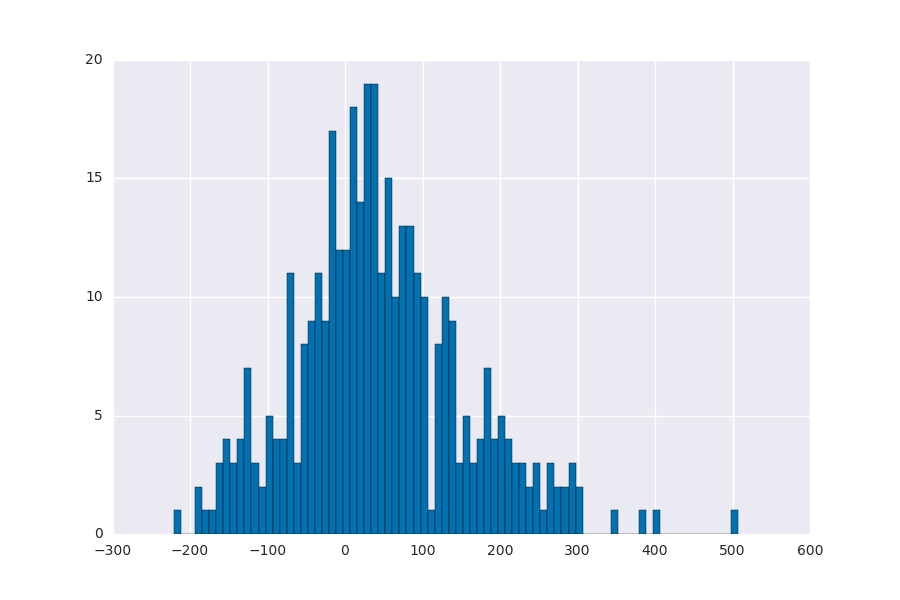

In [281]:
ii = [
    (0,0,0,0),
    (0,0,1,0),
    (0,1,0,0),
    (0,1,1,0),
    (1,0,0,0),
    (1,0,1,0),
    (1,1,0,0),
    (1,1,1,0),
    (2,0,0,0),
    (2,0,1,0),
    (2,1,0,0),
    (2,1,1,0),
    (3,0,0,0),
    (3,0,1,0),
    (3,1,0,0),
    (3,1,1,0),
]
j = [12]
guess = []
for k, i in enumerate(j):
    print(k, i, ii[i])
    for sign in [1, -1]:
        ii[i] = ii[i][:2] + (ii[i][2]+sign*0.5,) + ii[i][3:]
        P['guess'] = bsts[ii[i]].predict(F[make_features(rec[tags[ii[i][0]]].featsdata[ii[i][1]].feats)])*2-1
        P.guess = P.guess*(np.abs(P.guess)>=0.0)

        P['trade'] = P.guess*P.upDown*P[tags[ii[i][0]]+'_weight']
        std = P.trade.std(ddof=0)
        P.trade /= std
        guess.append(P.trade)

P.trade = sum(guess)
daily = P[ho].groupby('time').trade.sum()

print(daily.mean()/daily.std(ddof=0))
plt.hist(daily, bins=80);